# Correlated Collaborative Recommendations

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
warnings.filterwarnings('ignore')

users_data   = pd.read_csv('u.data', sep = '\t', names = ['user_id','item_id', 'rating','timestamp'])
movie_titles = pd.read_csv('Movie_Titles.csv', encoding= 'unicode_escape')

df  = pd.merge(left  = users_data,  
               right = movie_titles, 
               how   = 'inner',
               on    = 'item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


### Compute counts and mean ratings for recommendations

In [2]:
num_ratings = pd.DataFrame((df.groupby('title')['rating'].count().reset_index().rename(columns = {'rating':'TotalRatingCount'})))

avg_ratings = pd.DataFrame((df.groupby('title')['rating'].mean().reset_index().rename(columns = {'rating':'AvarageRating'})))


avg_ratings = pd.merge(avg_ratings, num_ratings, on = 'title')

avg_ratings.sort_values(by = ['TotalRatingCount'] , ascending = False).head(10)


,title,AvarageRating,TotalRatingCount
1399,Star Wars (1977),4.358491,583
334,Contact (1997),3.803536,509
499,Fargo (1996),4.155512,508
1235,Return of the Jedi (1983),4.007890,507
861,Liar Liar (1997),3.156701,485
461,"English Patient, The (1996)",3.656965,481
1285,Scream (1996),3.441423,478
1524,Toy Story (1995),3.878319,452
33,Air Force One (1997),3.631090,431
745,Independence Day (ID4) (1996),3.438228,429


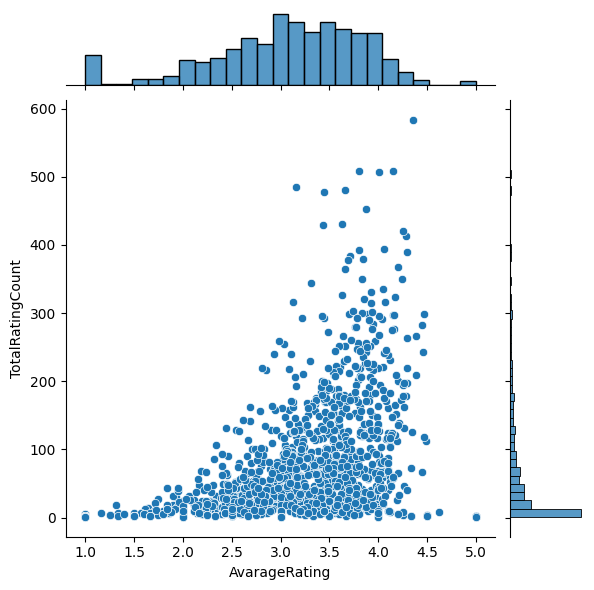

In [3]:
sns.jointplot(x='AvarageRating', y='TotalRatingCount', data=avg_ratings)

### Create User-Product Matrix

In [4]:
user_productM = df.pivot_table(index='user_id', columns='title', values='rating')
user_productM.head(10)

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0
6,NaN,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,3.0,NaN,NaN,NaN,5.0,3.0,NaN,3.0,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Recommendations based on Correlations
#### Examples
- Fargo
- Return of the Jedi

In [5]:
Fargo_user_rating = user_productM['Fargo (1996)']
RJedi_user_rating = user_productM['Return of the Jedi (1983)']

In [6]:
similarities_with_RJedi = pd.DataFrame(user_productM.corrwith(RJedi_user_rating), 
                                       columns = ['Correlations']).dropna()

similarities_with_Fargo = pd.DataFrame(user_productM.corrwith(Fargo_user_rating), 
                          columns=['Correlations']).dropna()

print(similarities_with_Fargo.head(10))
print(similarities_with_RJedi.head(10))

                                     Correlations
title                                            
'Til There Was You (1997)                0.100000
1-900 (1994)                             0.866025
101 Dalmatians (1996)                   -0.245368
12 Angry Men (1957)                      0.098676
187 (1997)                               0.142509
2 Days in the Valley (1996)              0.338319
20,000 Leagues Under the Sea (1954)      0.270497
2001: A Space Odyssey (1968)             0.299882
39 Steps, The (1935)                     0.008565
8 1/2 (1963)                             0.144686
                                     Correlations
title                                            
'Til There Was You (1997)                1.000000
1-900 (1994)                            -0.828079
101 Dalmatians (1996)                    0.165659
12 Angry Men (1957)                     -0.026169
187 (1997)                               0.064155
2 Days in the Valley (1996)              0.047452


### Filter Recommendations

In [7]:
similarities_with_RJedi = pd.merge(similarities_with_RJedi, num_ratings, on = 'title' )
similarities_with_Fargo = pd.merge(similarities_with_Fargo, num_ratings, on = 'title' )

- Specify criteria for filtering

In [8]:
criteria_RJedi1 = similarities_with_RJedi[similarities_with_RJedi['TotalRatingCount'] > 100].sort_values(by = 'Correlations', ascending = False).head(10)
criteria_RJedi1.drop(index = 1052, inplace = True)

Text(0, 0.5, 'Movie Title')

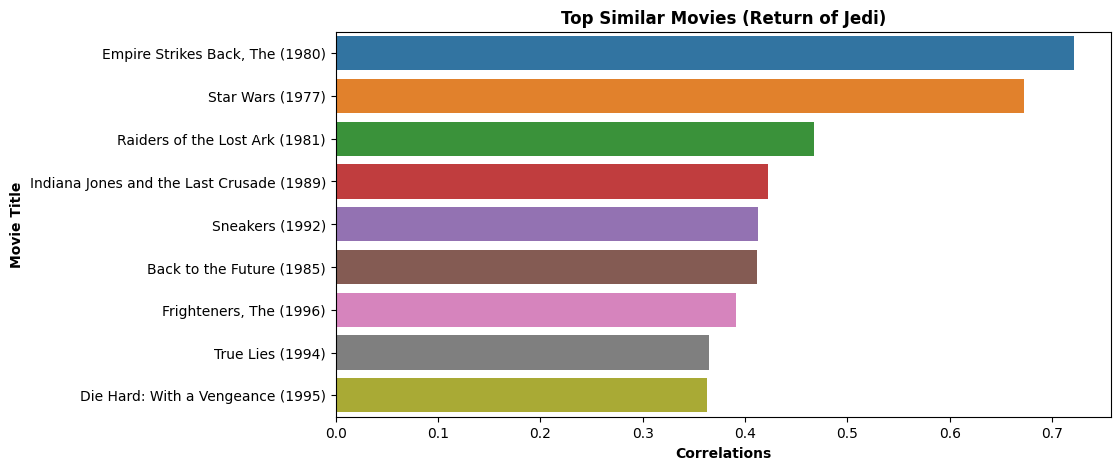

In [9]:
plt.figure(figsize=(10,5))
axis1 = sns.barplot(x = criteria_RJedi1['Correlations'].head(10), 
                    y = criteria_RJedi1['title'].head(10), 
                    data = criteria_RJedi1)

plt.title('Top Similar Movies (Return of Jedi)', weight='bold')
plt.xlabel('Correlations', weight='bold')
plt.ylabel('Movie Title', weight='bold')

In [10]:
criteria_Fargo1 = similarities_with_Fargo[similarities_with_Fargo['TotalRatingCount'] > 100].sort_values(by = 'Correlations', ascending = False).head(10)
criteria_Fargo1.drop(index = 422, inplace = True)

Text(0, 0.5, 'Movie Title')

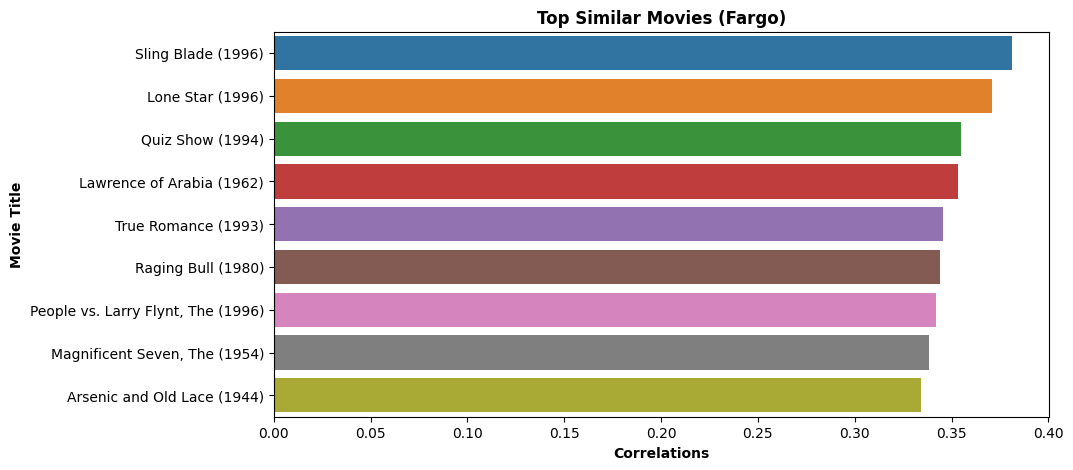

In [11]:
plt.figure(figsize=(10,5))
axis1 = sns.barplot(x = criteria_Fargo1['Correlations'].head(10), 
                    y = criteria_Fargo1['title'].head(10), 
                    data = criteria_Fargo1)

plt.title('Top Similar Movies (Fargo)', weight='bold')
plt.xlabel('Correlations', weight='bold')
plt.ylabel('Movie Title', weight='bold')